# Halo Photometry Mock Example

## In this notebook we will use real K2 data to mock up a moving PSF of variable dimensions.

## We will then generate target pixel files from this PSF and an input lightcurve, and see if Total Variation regularization works to detrend this - spoilers: it does!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import scipy.optimize as optimize
import fitsio
from time import time as clock

% matplotlib inline

import matplotlib as mpl

print mpl.style.available
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=18               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12


[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'_classic_test', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn', u'seaborn-dark-palette']


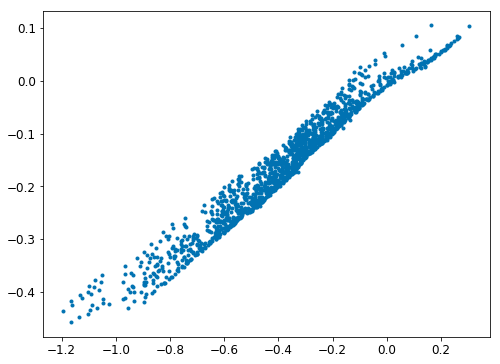

In [4]:
fname = './EPIC_211309989_mast.fits' # point this path to your favourite K2SC light curve
lc = Table.read(fname)

x, y = lc['x'][150:1550], lc['y'][150:1550]

ncad = np.size(x)

plt.plot(x,y,'.')

In [5]:
t = np.linspace(0,100,ncad)

f = 20*np.ones(ncad) + np.sin(t/6.) # make this whatever function you like! 
f[400:500] *= 0.995 # toy transit

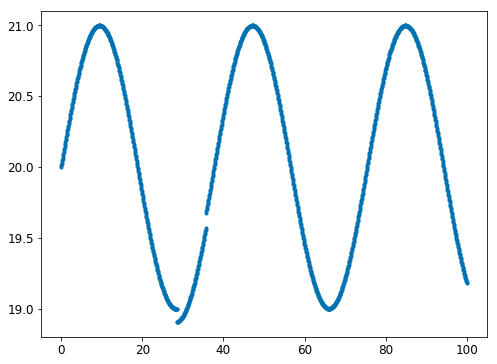

In [6]:
plt.plot(t,f,'.')

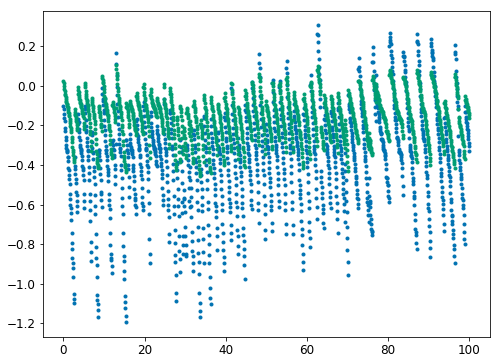

In [7]:
plt.plot(t,x,'.')
plt.plot(t,y,'.')

## Now we want to compute a PSF

In [8]:
def gaussian_psf(pixels,xp,yp,width):
    # make rr array
    npix = np.shape(pixels[0])[0]
    xx,yy = np.meshgrid(np.arange(npix)-npix/2.,np.arange(npix)-npix/2.)
    rr2 = (xx-xp)**2 + (yy-yp)**2
    
    return 1./(width*np.sqrt(2.*np.pi))*np.exp(-0.5*(rr2/width**2))

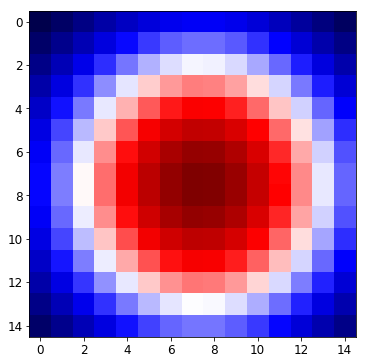

In [9]:
width = 5
pixels = np.zeros((15,15))
psf = gaussian_psf(pixels,x[0],y[0],width)
cmap = mpl.cm.seismic
plt.imshow(psf,interpolation='None',cmap=cmap)

In [10]:
tpf = np.zeros((15,15,ncad))
sensitivity = 1-0.05*np.random.rand(15,15)

for j in range(ncad):
    tpf[:,:,j] = f[j]*gaussian_psf(pixels,x[j]*3.,y[j]*3.,width/2.)*sensitivity + np.random.randn(15,15)*0.001

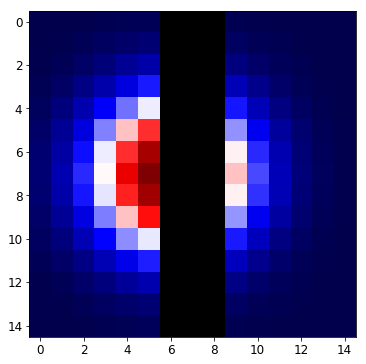

In [11]:
tpf[:,6:9,:] = np.nan

cmap = mpl.cm.seismic
cmap.set_bad('k')

plt.imshow(tpf[:,:,20],interpolation='None',cmap=cmap)

In [12]:
tpf_masked = np.delete(tpf,[6,7,8],1)

# plt.imshow(tpf_masked[:,:,1],interpolation='None')

pixelvectors = np.reshape(tpf_masked,(180,ncad))
print pixelvectors.shape

(180, 1400)


In [13]:
'''------------------------------------------
Define functions here - all have equiv in
the main halophot package
------------------------------------------'''

def diff_1(z):
    return np.sum(np.abs(z-np.roll(z,1)))

def diff_2(z):
    return np.sum(np.abs(2*z-np.roll(z,1)-np.roll(z,2)))

def obj_1(weights):
    flux = np.dot(weights.T,pixelvectors)
    return diff_1(flux)/np.nanmedian(flux)

def obj_2(weights):
#     return np.dot(w.T,sigma_flux,w)
    flux = np.dot(weights.T,pixelvectors)
    return diff_2(flux)/np.nanmedian(flux)

def obj_1_log(weights):
    wv = 10**(weights)
    wv /= np.sum(wv)
    flux = np.dot(wv.T,pixelvectors)
    return diff_1(flux)/np.nanmedian(flux)
                      
def tv_tpf(pixelvector):
    npix = np.shape(pixelvector)[0]
    cons = ({'type': 'eq', 'fun': lambda z: z.sum() - 1.})
    bounds = npix*((0,1),)
    w_init = np.ones(npix)/np.float(npix)
    def objective_1(weights):
        flux = np.dot(weights.T,pixelvector)
        return diff_1(flux)/np.nanmedian(flux)
    res1 = optimize.minimize(objective_1, w_init, method='SLSQP', constraints=cons, bounds = bounds,
                        options={'disp': True})
    xbest_1 = res1['x']
    lc_opt_1 = np.dot(xbest_1.T,pixelvector)
    return xbest_1, lc_opt_1

# def tv_logspace(pixelvector):
#     npix = np.shape(pixelvector)[0]
#     cons = ({'type': 'eq', 'fun': lambda z: z.sum() - 1.})
#     bounds = npix*((0,1),)
#     w_init = np.zeros(npix)/np.float(npix)
#     def objective_1(weights):
#         wv = 10**(weights)
#         wv /= np.sum(wv)
#         flux = np.dot((wv.T,pixelvector)
#         return diff_1(flux)/np.nanmedian(flux)
#     res1 = optimize.minimize(objective_1, w_init, method='Powell', constraints=cons, bounds = bounds,
#                         options={'disp': True})
#     xbest_1 = res1['x']
#     lc_opt_1 = np.dot(xbest_1.T,pixelvector)
#     return xbest_1, lc_opt_1

In [14]:
cons = ({'type': 'eq', 'fun': lambda z: z.sum() - 1.})
bounds = 180*((0,1),)

w_init = np.random.rand(180)
w_init /= np.sum(w_init)
# w_init = np.ones(180)/180.
    
res1 = optimize.minimize(obj_1, w_init, method='SLSQP', constraints=cons, bounds = bounds,
                        options={'disp': True})
xbest_1 = res1['x']

res2 = optimize.minimize(obj_2, xbest_1, method='SLSQP', constraints=cons, bounds = bounds,
                        options={'disp': True})
xbest_2 = res2['x']


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.609820172774
            Iterations: 76
            Function evaluations: 13992
            Gradient evaluations: 76
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.77477715055
            Iterations: 19
            Function evaluations: 3510
            Gradient evaluations: 19


In [15]:
# xbest_1, lc_opt_1 = tv_tpf(pixelvectors)

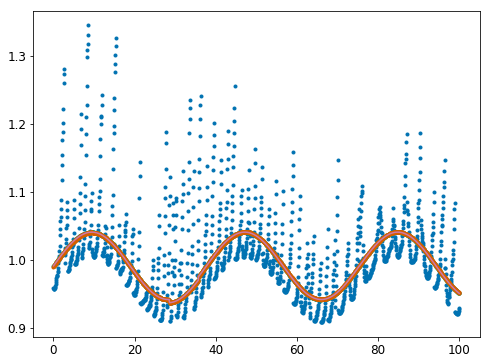

In [16]:
'''------------------------------------------
Plot light curves
------------------------------------------'''

lc_opt_1 = np.dot(xbest_1.T,pixelvectors)
lc_opt_2 = np.dot(xbest_2.T,pixelvectors)

raw_lc = np.sum(pixelvectors,axis=0)

plt.plot(t,raw_lc/np.nanmedian(raw_lc),'.')
plt.plot(t,lc_opt_1/np.nanmedian(lc_opt_1),'.')
plt.plot(t,lc_opt_2/np.nanmedian(lc_opt_2),'.')
# plt.plot(t,lc_opt_l1/np.nanmedian(lc_opt_l1),'.')
plt.plot(t,f/np.nanmedian(f),'-')


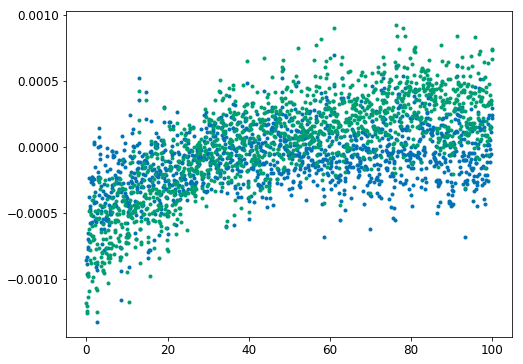

In [18]:
'''------------------------------------------
Plot residuals
------------------------------------------'''

plt.plot(t,lc_opt_1/np.nanmedian(lc_opt_1)-f/np.nanmedian(f),'.')
plt.plot(t,lc_opt_2/np.nanmedian(lc_opt_2)-f/np.nanmedian(f),'.')


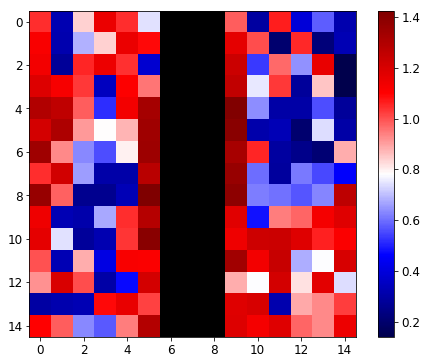

In [19]:
'''------------------------------------------
Plot a map of the weights you infer
------------------------------------------'''

weightmap = np.zeros((tpf_masked.shape[0],tpf_masked.shape[1]))
weightmap.ravel()[:] = xbest_1[:]
# weightmap.ravel()[:] = weights_log_1[:]
weightmap = np.insert(weightmap,[6,6,6],np.nan,axis=1)

plt.clf()
cmap = mpl.cm.seismic
cmap.set_bad('k')
norm = np.size(weightmap)
plt.imshow((weightmap*norm)**0.2,cmap=cmap,
    interpolation='None')
plt.colorbar()


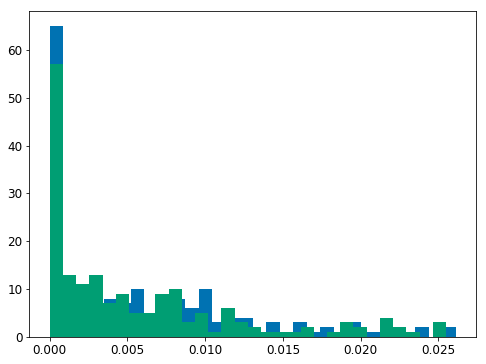

In [20]:
'''------------------------------------------
Histogram of the the weights
------------------------------------------'''

h = plt.hist(xbest_1,bins=30)
k =  plt.hist(xbest_2,bins=30)